# Statistical Learning - Linear Dimension Reduction

---

## Contents

### [Subset Selection](#subset-selection)
   - [Best Subset Selection](#best-subset-selection)
   - [Forward Stepwise Selection](#fwd-stepwise-selection)
   - [Backward Stepwise Selection](#bwd-stepwise-selection)
   - [Choosing the Optimal Model](#choosing-best)


### [Shrinkage Methods](#shrinkage)
   - [Ridge Regression](#ridge)
   - [Lasso Regression](#lasso)
   
   
### [Dimension Reduction Methods](#dimension-reduction)
   - [Principal Components Regression](#pcr)
   - [Partial Least Squares](#pls)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns
from scipy import stats
from IPython.display import Image
from IPython.core.display import HTML 

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from itertools import combinations

np.set_printoptions(suppress=True)
%matplotlib inline
plt.style.use("fivethirtyeight")

---

## Datasets

_Credit Dataset_

In [2]:
cred = pd.read_csv("data/credit.csv")
cred.drop(["Unnamed: 0"], axis = 1, inplace = True)
cred["Student"].replace({"Yes": 1, "No": 0}, inplace = True)
cred["Married"].replace({"Yes": 1, "No": 0}, inplace = True)
cred["Gender"].replace({" Male": 1, "Female": 0}, inplace = True)
cred.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,1,0,1,Caucasian,333
1,106.025,6645,483,3,82,15,0,1,1,Asian,903
2,104.593,7075,514,4,71,11,1,0,0,Asian,580
3,148.924,9504,681,3,36,11,0,0,0,Asian,964
4,55.882,4897,357,2,68,16,1,0,1,Caucasian,331


---

<a id="subset-selection"></a>
# Subset Selection

Il processo di *subset selection* ha l'obiettivo di individuare il corretto sottoinsieme di predittori da associare alla *response*. Esistono diversi approcci possibili.

---

<a id="best-subset-selection"></a>
## Best Subset Selection

E' necessario addestrare una regressione lineare per ciascuna combinazione possibile dei $p$ *predictors*. In parole povere, si fittano tutti i $p$ modelli che contengono un solo predittore, tutti i $\binom{p}{2}$ modelli che contengono esattamente due predittori, tutti i $\binom{p}{3}$ modelli che contengono esattamente tre predittori e così via.

Riassumiamo la *best subset selection* in forma algoritmica:

- Si parte dal *null model* $M_0$, che non contiene predittori e restituisce sempre la *mean response* per ogni input.


- Per $k=1,\dots,p$:
   - Si fittano i $\binom{p}{k}$ modelli che contengono $k$ predittori.
   - Si individua il modello che fitta meglio il training set e lo si denota con $M_k$. La metrica di riferimento per valutare il fit del training set è la *RSS* o l'*R-squared*.


- Ora che si hanno a disposizione i modelli $M_0,\dots,M_p$, si individua il migliore di questi usando la *CV*, l'*AIC*, il *BIC* o l'*Adjusted-R-squared*.

La *best subset selection* è concettualmente semplice, ma soffre di limitazioni computazionali. Anche solo con 10 predittori, bisogna valutare 1000 modelli diversi!

---

<a id="fwd-stepwise-selection"></a>
## Forward Stepwise Selection

Si inizia con il *null model* e si aggiungono predittori uno alla volta fin quando tutti sono inclusi nel modello. Ad ogni step, però, si aggiunge al modello solo la variabile che fornisce il maggior incremento addizionale al fitting dei dati.

Riassumiamo la *forward stepwise selection* in forma algoritmica:

- Si parte dal *null model* $M_0$, che non contiene predittori e restituisce sempre la *mean response* per ogni input.


- Per $k=0,\dots,p-1$:
   - Ho già a disposizione il modello $M_k$. Si addestrano tutti i $p-k$ modelli che derivano dall'aggiunta di un ulteriore predittore rispetto a quelli contenuti in $M_k$.
   - Scelgo il migliore fra questi $p-k$ modelli e lo chiamo $M_{k+1}$. Il modello migliore è quello che meglio fitta i dati di training, quindi lo individuo analizzando i valori di *RSS* o *R-Squared*.
   
   
- Ora che si hanno a disposizione i modelli $M_0,\dots,M_p$, si individua il migliore di questi usando la *CV*, l'*AIC*, il *BIC* o l'*Adjusted-R-squared*.

Al posto di addestrare $2^p$ modelli come nella *best subset selection*, in questo caso si fittano $p-k$ modelli ad ogni iterazione, con $k$ che aumenta ad ogni step fino a raggiungere $p-1$. In totale, si tratta di $1+p(p+1)/2$ modelli.

Specifichiamo che questo approccio non garantisce l'individuazione del sottoinsieme di predittori ideali, cioè non ha la certezza di restituire il migliore fra tutti i $2^p$ modelli possibili. 

Facciamo un esempio: se ho tre predittori e il miglior modello univariato contiene $X_1$, tutti i modelli successivi conterranno sempre $X_1$; è possibile, però, che il miglior modello bivariato sia quello contenente $X_2$ e $X_3$, e la procedura non sarà mai in grado di individuarlo.

---

<a id="bwd-stepwise-selection"></a>
## Backward Stepwise Selection

Si parte dal *full model* contenente tutti i predittori, e ad ogni step si rimuove quello che sembra fornire il peggior contributo al fitting dei dati di training.

Riassumiamo la *backward stepwise selection* in forma algoritmica:

- Si parte dal *full model* $M_p$, che contiene tutti i predittori.


- Per $k=p,p-1,p-2,\dots,1$:
   - Ho già a disposizione il modello $M_p$. Si addestrano tutti i $k$ modelli che derivano dalla rimozione di uno dei predittori già contenuti in in $M_k$.
   - Scelgo il migliore fra questi $k$ modelli e lo chiamo $M_{k-1}$. Il modello migliore è quello che meglio fitta i dati di training, quindi lo individuo analizzando i valori di *RSS* o *R-Squared*.
   
   
- Ora che si hanno a disposizione i modelli $M_0,\dots,M_p$, si individua il migliore di questi usando la *CV*, l'*AIC*, il *BIC* o l'*Adjusted-R-squared*.

Anche in questo caso il numero totale di modelli analizzati è $1+p(p+1)/2$, e anche in questo caso non c'è garanzia di individuare il migliore fra i $2^p$ modelli totali.

---

<a id="choosing-best"></a>
## Choosing the Optimal Model

In tutti gli approcci proposti è sempre presente uno step incentrato sull'individuazione del modello che meglio lavora sui dati di test. Ci sono due tecniche per risolvere tale problema:

- Stimare *indirettamente* il *test error* applicando una sorta di *adjustment* al *training error*, che tenga conto dell'overfitting e del numero di predittori.


- Stimare *direttamente* il *test error* usando la *cross-validation*.

Abbiamo dimostrato come il *training MSE* non sia altro che una sottostima del *test MSE*. Esistono però delle metriche che sfruttano la *RSS* di *training* per costruire una più affidabile del *test error*: *Mallow's $C_p$*, *Akaike Information Criterion*, *Bayesian Information Criterion* e *Adjusted R-squared*.

Per un modello con $d$ predittori, la stima del *test MSE* prodotta dal **Mallow's $C_p$** deriva dalla seguente formulazione:

$$\large C_p=\frac{1}{n}\left(RSS+2d\hat{\sigma}^2\right)$$

Il valore $\hat{\sigma}^2$ è una stima della variabilità dell'*error term* $\epsilon$ associato a ciascuna misurazione della *response*. In genere, tale stima si costruisce a partire dal *full model* e non dal modello a $d$ predittori per il quale si sta calcolando il *test MSE*.

Notiamo come $C_p$ aggiunga una penalità alla *training RSS* in modo da compensare la decrescita nativa di *RSS* all'aggiunta di nuovi predittori.

Per un modello con $d$ predittori, la stima del *test MSE* prodotta dall'**Akaike Information Criterion** deriva dalla seguente formulazione:

$$\large AIC=\frac{1}{n\hat{\sigma}^2}\left(RSS+2d\hat{\sigma}^2\right)$$

Essendo proporzionali fra loro, spesso solo uno fra l'*AIC* e il *Cp* è riportato nelle analisi.

Per un modello con $d$ predittori, la stima del *test MSE* prodotta dal **Bayesian Information Criterion** deriva dalla seguente formulazione:

$$\large BIC=\frac{1}{n\hat{\sigma}^2}\left(RSS+log(n)d\hat{\sigma}^2\right)$$

Siccome $log(n)>2$ per qualsiasi $n>7$, è possibile osservare come la *BIC* applichi una penalità maggiore a modelli con più variabili, e quindi porti il processo di *model selection* a isolare modelli mediamente più piccoli.

Per un modello con $d$ predittori, la stima del *test MSE* prodotta dall'**Adjusted $R^2$** deriva dalla seguente formulazione:

$$\large Adj.R^2=1-\frac{RSS/(n-d-1)}{TSS/(n-1)}$$

Al contrario del *Cp*, dell'*AIC* e del *BIC*, che assumono valori bassi per indicare un basso *test error*, l'*Adjusted R-squared* assume valori alti per indicare modelli molto performanti.

<br>

La **cross-validation** rappresenta un valido rivale per le quattro metriche appena descritte. Ci sono tre vantaggi chiave: la *CV* calcola direttamente una stima del *test error*, compie meno assunzioni sul modello sottostante e può essere usate per una gran varietà di task, specialmente in quelli in cui è molto difficile stimare la variabilità dell'*error term* $\sigma^2$.

Le metriche appena descritte sono diventate famose perché non gravano sul processo dal punto di vista computazionale, al contrario della *CV*.

<br>

Usiamo la **CV** e la **stepwise forward selection** per individuare il miglior set di predittori del dataset *credit*, che ha come *response* la variabile *balance*:

In [3]:
df = cred.copy()
df = pd.get_dummies(df, columns=["Ethnicity"])
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,1,0,1,333,0,0,1
1,106.025,6645,483,3,82,15,0,1,1,903,0,1,0
2,104.593,7075,514,4,71,11,1,0,0,580,0,1,0
3,148.924,9504,681,3,36,11,0,0,0,964,0,1,0
4,55.882,4897,357,2,68,16,1,0,1,331,0,0,1


In [4]:
response = "Balance"
X = df.drop(response, axis = 1)
Y = df[response]

k = len(X.columns)

remaining_features = list(X.columns)
best_features = list()
r2_list = list()
features_dict = dict()

for i in range(1, k + 1):
    best_r2 = 0
    for combo in combinations(remaining_features, 1):
        model = LinearRegression()
        model.fit(X[list(combo) + best_features], Y)
        r2 = model.score(X[list(combo) + best_features], Y)
        
        if r2 > best_r2:
            best_r2 = r2
            best_feature = combo[0]

    best_features.append(best_feature)
    remaining_features.remove(best_feature)
    
    r2_list.append(best_r2)
    features_dict[i] = best_features.copy()

In [5]:
result_df = pd.DataFrame({"num_preds": list(features_dict.keys()),
                          "features": ["-".join(v) for k, v in features_dict.items()],
                          "R2": r2_list})
result_df

,num_preds,features,R2
0,1,Rating,0.745848
1,2,Rating-Income,0.875118
2,3,Rating-Income-Student,0.949879
3,4,Rating-Income-Student-Limit,0.952188
4,5,Rating-Income-Student-Limit-Cards,0.954161
5,6,Rating-Income-Student-Limit-Cards-Age,0.954688
6,7,Rating-Income-Student-Limit-Cards-Age-Gender,0.954817
7,8,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.954933
8,9,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955014
9,10,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955066


Dopo aver individuato i migliori modelli per ciascun numero di predittori, usiamo la *CV* per trovare quello che performa meglio sui dati di test.

In [6]:
X = df.drop(response, axis = 1)
Y = df[response]

cv = KFold(n_splits = 10, shuffle = True, random_state = 888)

test_mse_list = list()

for features in features_dict.values():
    errors = list()
    X_feats = X[features]
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = np.array(X_feats)[train_idx], np.array(X_feats)[test_idx]
        Y_train, Y_test = np.array(Y)[train_idx], np.array(Y)[test_idx]
        model = LinearRegression()
        model.fit(X_train, Y_train)
        errors.append(mean_squared_error(Y_test, model.predict(X_test)))
    test_mse_list.append(np.mean(errors))
result_df["Test MSE"] = test_mse_list

In [7]:
result_df.sort_values(by = "Test MSE", ascending = True)

,num_preds,features,R2,Test MSE
5,6,Rating-Income-Student-Limit-Cards-Age,0.954688,9961.655565
6,7,Rating-Income-Student-Limit-Cards-Age-Gender,0.954817,9967.686292
4,5,Rating-Income-Student-Limit-Cards,0.954161,9997.186362
7,8,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.954933,10019.342119
8,9,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955014,10027.230548
9,10,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955066,10055.047179
11,12,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955102,10106.516999
10,11,Rating-Income-Student-Limit-Cards-Age-Gender-E...,0.955102,10106.516999
3,4,Rating-Income-Student-Limit,0.952188,10409.898442
2,3,Rating-Income-Student,0.949879,10830.443518


Il modello con 6 predittori è associato al valore più basso di *test MSE*!

---

<a id="shrinkage-methods"></a>
# Shrinkage Methods

I metodi di *subset selection* utilizzano il *least squares criterion* per addestrare un modello lineare contenente solo un sottoinsieme dei predittori totali. In alternativa, è possibile fittare un modello contenente tutti i predittori e applicare delle tecniche che *regolarizzino* o più semplicemente *riducano* i valori delle stime dei *model parameters*.

---

<a id="ridge"></a>
## Ridge Regression

Il *least squares criterion* stima i coefficienti del modello lineare provando a minimizzare la *RSS*. Il problema di minimizzazione della *ridge regression* è leggermente diverso:

$$\large minimize_{\beta_i}\;\; RSS+\lambda\sum_{j=1}^{p}\beta_j^2$$

Il termino aggiunto è un **regularization term**, caratterizzato dal **regularization parameter** $\lambda\geq0$. Così come per il *LSC* originale, questo nuovo problema cerca le stime parametriche attraverso una minimizzazione della *RSS*, ma allo stesso tempo presenta una **shrinkage penalty** che può essere minimizzata solo se i *model coefficients* presentano valori vicini a zero.

Il *tuning parameter* $\lambda$ serve a controllare l'impatto relativo di questi due termini: se $\lambda=0$, non c'è penalità, e la ridge produce le stesse stime del *LSC*; se $\lambda\rightarrow\infty$, invece, l'impatto della penalità aumenta e le stime tendono a zero.

Notiamo come la penalità non si applichi all'*intercept* $\beta_0$, che rappresenta solo il valore medio della *response* quando i predittori sono nulli.

Specifichiamo, inoltre, che è meglio applicare la ridge dopo aver standardizzato i predittori, cioè dopo aver applicato la seguente trasformazione:

$$\large \tilde{x}_{ij}=\frac{x_{ij}}
{\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij}-\bar{x}_j)^2}}$$

Il denominatore non è altro che la stima della deviazione standard del predittore *j-esimo*. Così facendo tutti i predittori presenteranno deviazione standard unitaria.

Il vantaggio principale che ci porta ad utilizzare la ridge è legato al *bias-variance trade-off*: all'aumentare di $\lambda$, infatti, diminuisce la flessibilità e di conseguenza la varianza, costringendo il bias ad aumentare.

In realtà la decrescita di varianza è molto più pronunciata rispetto all'aumento di bias, almeno per i primi valori di $\lambda$ dopo lo zero, aumentando la qualità predittiva del modello. Ad un certo punto, però, la decrescita di varianza tende a spegnersi, e la grossa penalità sui valori dei coefficienti causa un ampio aumento di bias nel modello.

In generali, le stime del *LSC* tendono ad essere associate con bias molto basso ed alta varianza, in particolare quando la relazione *predictors-response* è realmente lineare. Quest'alta varianza si riscontra nel forte impatto che un piccolo cambio nel *training set* può avere nelle stime parametriche del modello.

Di conseguenza, la ridge funziona particolarmente bene in situazioni in cui le stime del *LSC* sono associate ad alta variabilità!

---

<a id="lasso"></a>
## Lasso Regression

La ridge ha un ovvio svantaggio, cioè include sempre tutti i predittori nel modello finale. La **L2 Penalty** che la caratterizza limita i valori di tutti i coefficienti, ma non è capace di fissarne alcuno ad esattamente zero. Questo non rappresenta un problema per l'accuratezza predittiva, ma può rivelarsi problematico ai fini della *model interpretation* se ci sono tanti predittori.

La differenza fra ridge e lasso sta nella penalty:

$$\large minimize_{\beta_i}\;\; RSS+\lambda\sum_{j=1}^{p}|\beta_j|$$

In altre parole, la lasso adotta la **L1 Penalty** e non la *L2 Penalty*. Analogamente alla ridge, la lasso è in grado di limitare i valori dei coefficienti del modello, ma è anche capace di annullarli completamente, a patto che $\lambda$ sia sufficientemente grande.

In altre parole, in maniera simile alle tecniche di *subset selection*, la lasso implementa una forma di *variable selection*.

Non è possibile affermare quale dei due metodi di regolarizzazione sia superiore all'altro. In generale, ci si aspetta che la lasso performi meglio in scenari in cui solo pochi predittori hanno dei coefficienti importanti, mentre tutti gli altri sono associati a valori piccoli o quasi nulli. La ridge, al contrario, funziona meglio quando la *response* è funzione di molti predittori, tutti con coefficienti di dimensioni confrontabili.

---

<a id="dimension-reduction"></a>
# Dimension Reduction Methods

Si tratta si una serie di tecniche usano delle versioni trasformate dei predittori per addestrare un modello lineare con il *least squares criterion*.

Siano $Z_1,\dots,Z_M$ delle combinazioni lineari dei $p$ predittori originali, dove $M<p$. A livello matematico, vuol dire:

$$\large Z_j=\sum_{i=1}^{p}\phi_{ij}X_i$$

In altre parole, ciascun predittore contribuisce al calcolo di ogni singolo $Z_j$, i termini $\phi_{ij}$ non sono altro che delle costanti che associano i diversi $Z_j$ ai predittori $X_i$.

Usando questi nuovi predittori $Z_j$, possiamo addestrare una regressione lineare:

$$\large y_i=\theta_0+\sum_{j=1}^{M}\theta_jz_{ij}+\epsilon_i$$

Ad esempio, con due predittori trasformati:

$$\large y_i=\theta_0+\theta_1z_{i1}+\theta_2z_{i2}+\epsilon_i$$

Questo approccio riduce il problema originale della stima di $p+1$ coefficienti $\beta_0,\dots,\beta_p$ ad un problema più semplice in cui si devono stimare solo $M+1$ coefficienti $\theta_0,\dots,\theta_M$.

Esistono due tecniche principali che utilizzano quest'approccio: *principal components* e *partial least squares*.

---

<a id="pcr"></a>
## Principal Components Regression

La *Principal Component Analysis* è una tecnica molto utilizzata in task di *unsupervised learning* per ricavare un insieme di *features* di bassa dimensione a partire da un insieme più grande di variabili. In questo caso, la utilizziamo come tecnica di *dimensionality reduction* per la regressione lineare.

Il cosiddetto **first principal component** è la *direzione* nei dati lungo la quale le osservazioni variano maggiormente. In altre parole, se proiettassimo le osservazioni su questa direzione/retta, l'insieme delle proiezioni risultanti presenterebbe la più grande varianza possibile rispetto a tutte le altre direzioni/rette.

<img src="imgs/pcr-simple.PNG"/>

A livello matematico, il *first principal component* dell'esempio presentato segue la seguente formulazione:

$$\large Z_1=0.839\times(X_1-\bar{X}_1)+0.544\times(X_2-\bar{X}_2)$$

Le costanti $\phi_{11}=0.839$ e $\phi_{21}=0.544$ prendono il nome di **principal component loadings**.

Se avessimo un dataset di $n=100$ osservazioni, dovremmo usare la formulazione del *first principal component* per costruire i cosiddetti **principal component scores** $z_{i1}$, che sarà ancora un array di 100 elementi e conterrà il valore delle osservazioni sul nuovo asse:

$$\large z_{i1}=0.839\times(X_{i1}-\bar{X}_{i1})
+0.544\times(X_{i1}-\bar{X}_{i1})$$

C'è anche un'altra interpretazione della PCA: il *first principal component* definisce la retta che si trova il più vicino possibile ai dati; a livello matematico, vuol dire che si tratta di quella retta che minimizza la somma delle distanze quadrate perpendicolari fra ciascun punto e la retta in questione. In parole povere, il *first principal component* è sempre scelto in modo che le osservazioni proiettate su di esso siano più vicine possibile alle osservazioni originali.

Possiamo pensare che i valori di $Z_1$ siano una sorta di riassunto dei valori di $X_1$ e $X_2$ per ciascuna osservazione. Ma com'è possibile che un singolo numero rappresenti contemporaneamente due predittori? In questo caso, sembra che le due *feature* siano associate ad una forte relazione lineare, quindi ci possiamo aspettare che una metrica a singolo numero funzioni bene.

Notiamo come ci sia una forte relazione lineare fra il *first PC* e le due *feature*; in altre parole, il *first PC* sembra in grado di inglobare gran parte dell'informazione contenuta nei due predittori.

<img src="imgs/pcr-first-corr.PNG"></img>

Abbiamo parlato solo del primo componente principale, ma tecnicamente potremmo costruire fino a $p$ *PC* distinti. Il secondo componente principale è una combinazione lineare di $X_1$ e $X_2$ che risulta non correlato con $Z_1$ e che, allo stesso tempo, presenta la maggior variabilità possibile rispetto alla proiezione delle osservazioni.

La condizione di zero correlazione fra i due *PC* equivale a imporre che essi debbano essere perpendicolari fra loro:

$$\large Z_2=0.544\times(X_1-\bar{X}_1)-0.839\times(X_2-\bar{X}_2)$$

Da notare come il primo *PC* conterrà sempre più informazioni di tutti gli altri *PC*.

<img src="imgs/pcr-second-corr.PNG"></img>

La **principal components regression** prevede la costruzione di $M$ *principal components* $Z_1,\dots,Z_M$ e l'utilizzo di quest'ultimi per costruire un modello lineare utilizzando il *LSC*.

L'idea di fondo della *PCR* è che dovrebbe bastare un piccolo numero di *PC* per spiegare gran parte della variabilità dei dati e, allo stesso tempo, la relazione dei predittori con la *response*.

In altre parole, l'assunzione di fondo della *PCR* è che le direzioni in cui i predittori mostrano la maggiore variazione devono necessariamente essere le direzioni lungo le quali essi sono associati con la *response*. Nonostante tale assunzione non sia sempre verificata, si tratta di una buona approssimazione della realtà.

Se l'assunzione centrale della *PCR* è rispettata, allora fittare un modello con $Z_1,\dots,Z_M$ porterà a risultati migliori rispetto al fittare un modello con $X_1,\dots,X_p$, dato che la quasi totalità delle informazioni sarà contenuta nei *PC* e usando meno *features* dovremmo essere in grado di mitigare l'*overfitting*.

In generali, più *PC* sono utilizzati nella *PCR*, più il bias della procedura tende a scendere, ed aumenta la varianza. Questo, come visto per il *bias-variance trade-off* porta al tipico andamento *U-shape* del *Test MSE*.

Specifichiamo che, nonostante la *PCR* ci porti ad addestrare un modello usando meno predittori, non si tratta di una tecnica di *feature selection*, in quanto in ciascuno dei nuovi $M$ predittori ci sarà un contributo di tutti i predittori originali.

Ricordiamo, infine, che la standardizzazione dei predittori è fondamentale nella *PCR*, e che in genere il numero di *PC* è ricavato tramite *CV*.

Applichiamo la *PCR* sul dataset *Credit*, analizzando le configurazioni ottenibili al variare del numero di componenti principali:

In [8]:
df = pd.get_dummies(cred, columns=["Ethnicity"])

response = "Balance"
X = df.drop(response, axis = 1)
Y = df[response]
cv = KFold(n_splits = 10, shuffle = True, random_state = 888)

mse_list = list()

for n_comps in range(1, len(X.columns) + 1):
    pca = PCA(n_components = n_comps)
    X_pca = pca.fit_transform(scale(X))
    errors = list()
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = np.array(X_pca)[train_idx], np.array(X_pca)[test_idx]
        Y_train, Y_test = np.array(Y)[train_idx], np.array(Y)[test_idx]
        model = LinearRegression()
        model.fit(X_train, Y_train)
        errors.append(mean_squared_error(Y_test,
                                         model.predict(X_test)))
    mse_list.append(np.mean(errors))

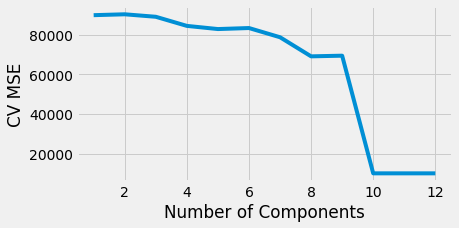

In [9]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(np.arange(1, 13), mse_list)
plt.xlabel("Number of Components")
plt.ylabel("CV MSE")
plt.show()

---

<a id="pls"></a>
## Partial Least Squares

La *PCR* si basa sull'individuazione delle *directions* o combinazioni lineari che meglio rappresentano i predittori $X_1,\dots,X_p$. Queste *directions* sono identificate in maniera non supervisionata, dato che la *response* non è usata per calcolarli.

Per questo motivo la *PCR* soffre di un problema: non c'è garanzia che le *directions* che meglio spiegano la variabilità dei predittori siano anche quelle che meglio spiegano la variabilità della *response*.

La **partial least squares** è un'alternativa supervisionata alla *PCR*.

Come per la *PCR*, si identifica un nuovo insieme di *features* $Z_1,\dots,Z_M$ costruite come combinazione lineare dei predittori originali, e si addestra un modello lineare con il *LSC*.

La differenza è che la *PLS* utilizza la *response* per identificare i nuovi predittori, cioè cerca le combinazioni lineari che meglio spiegano la variabilità dei predittori e che allo stesso tempo sono correlati con la *response*. E' come dire che la *PLS* prova a trovare delle *directions* che spiegano contemporaneamente sia la *response* che i *predictors*.

Dopo aver standardizzato i predittori, la *PLS* calcola la prima direzione $Z_1$ settando le costanti $\phi_{j1}$ uguali alla *slope* risultante da una regressione lineare di $Y$ su ciascun $X_j$.

<img src="imgs/pls.PNG"></img>

Nel plot precedente notiamo la prima *direction* della *PLS* come retta continua e il *first principal component* della *PCR* come retta tratteggiata. Si evidenzia come la *PLS* abbia scelto una *direction* che presenta minore variabilità per $X_2$ (*Ad Spending*) rispetto alla *PCR*; ciò vuol dire che probabilmente $X_1$ è maggiormente correlata con la *response*! In sostanza, le *directions* della *PLS* non fittano i predittori così bene, ma spiegano meglio la *response*.

Per identificare la seconda *directions* della *PLS* dobbiamo calcolare una regressione di ciascun'altra variabile su $Z_1$ e calcolarne i *residuals*. Tali residui possono essere interpretati come l'informazione rimanente che non è stata spiegata dalla prima *direction* della *PLS.

Il processo può essere ripetuto $M$ volte fin quando, ottenuti tutti i predittori d'interesse, si addestra un modello lineare usando $Z_1,\dots,Z_M$ per predire $Y$.

---